In [2]:
import psycopg2
from dotenv import load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import plotly.express as px

load_dotenv()

conn = psycopg2.connect(
    host=os.getenv("host"),
    port=os.getenv("port"),
    dbname=os.getenv("dbname"),
    user=os.getenv("user"),
    password=os.getenv("password"),
)

if conn:
    print('Connection Successful')

Connection Successful


/tmp/ipykernel_3262/701726892.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df1 = pd.read_sql(query1, conn)
/tmp/ipykernel_3262/701726892.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(query2, conn)


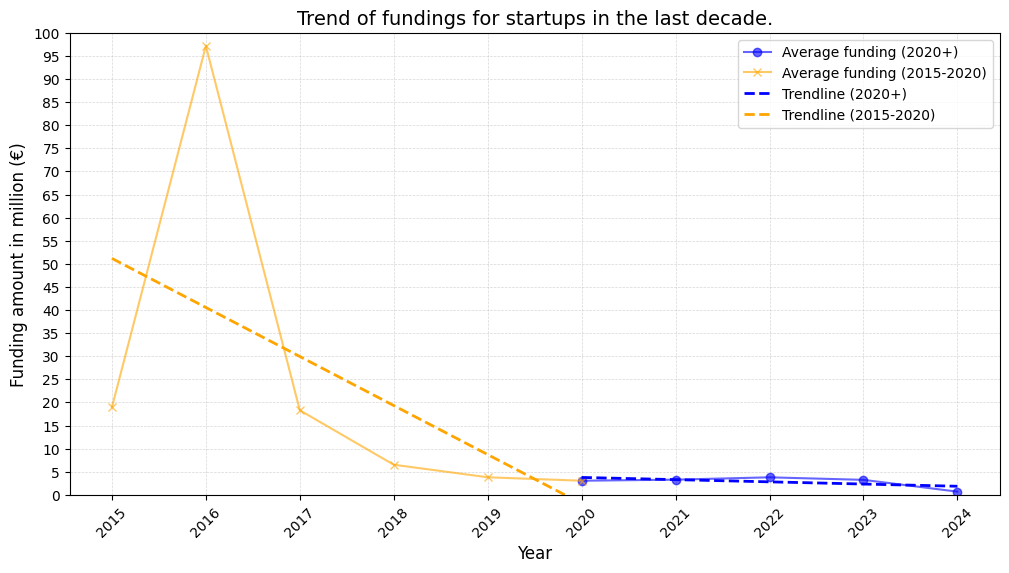

Overall funding trends over the last decade.
For the first half of the decade - Period 1 (2015-2020): 6 years analyzed - trend slope shows = -476,617.00
Funding is decreasing over time more rapidly.
For the second half of the decade - Period 2 (2020+): 5 years analyzed - trend slope shows = -10,613,583.00
Funding is decreasing over time. However compared to the first time period, the trend slope shows a slower descrease.


In [3]:
query1 = """
SELECT start_year,
       COUNT(*) AS num_companies,
       AVG(funding_amount) AS avg_funding
FROM company
WHERE funding_amount IS NOT NULL AND start_year IS NOT NULL AND funding_amount <> 'NaN' AND start_year >= 2020
AND start_year < 2025
GROUP BY start_year
ORDER BY start_year ASC;
"""
df1 = pd.read_sql(query1, conn)


query2 = """
SELECT start_year,
       COUNT(*) AS num_companies,
       AVG(funding_amount) AS avg_funding
FROM company
WHERE funding_amount IS NOT NULL AND start_year IS NOT NULL AND funding_amount <> 'NaN' AND start_year >= 2015 AND start_year < 2021
GROUP BY start_year
ORDER BY start_year ASC;
"""
df2 = pd.read_sql(query2, conn)


# Fit linear regression trendlines
def fit_trendline(df):
    X = df['start_year'].values.reshape(-1,1)
    y = df['avg_funding'].values
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    return y_pred, model.coef_[0], model.intercept_

trend1, slope1, intercept1 = fit_trendline(df1)
trend2, slope2, intercept2 = fit_trendline(df2)

# Normalize data
df1['avg_funding_m'] = df1['avg_funding'] / 1e6
df2['avg_funding_m'] = df2['avg_funding'] / 1e6
trend1_m = trend1 / 1e6
trend2_m = trend2 / 1e6


# Plot raw data and trendlines
plt.figure(figsize=(12,6))

# Raw data
plt.plot(df1['start_year'], df1['avg_funding_m'], marker='o', color='blue', label='Average funding (2020+)', alpha = 0.6)
plt.plot(df2['start_year'], df2['avg_funding_m'], marker='x', color='orange', label='Average funding (2015-2020)', alpha = 0.6)

# Trendlines
plt.plot(df1['start_year'], trend1_m, color='blue', linestyle='--', label='Trendline (2020+)', linewidth = 2)
plt.plot(df2['start_year'], trend2_m, color='orange', linestyle='--', label='Trendline (2015-2020)', linewidth = 2)

plt.xlabel('Year', size = 12)
plt.ylabel('Funding amount in million (€)', size = 12)
plt.title('Trend of fundings for startups in the last decade.', size = 14)

# Customize y-axis
plt.ylim(0, 100)  
plt.yticks(np.arange(0, 101, 5))  

all_years = sorted(set(df1['start_year']).union(set(df2['start_year'])))
plt.xticks(all_years, rotation=45)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()


# Print insights
print("Overall funding trends over the last decade.")
print(f"For the first half of the decade - Period 1 (2015-2020): {df2.shape[0]} years analyzed - trend slope shows = {round(slope1,0):,.2f}")
if slope1 > 0:
    print("Funding is increasing over time.")
else:
    print("Funding is decreasing over time more rapidly.")

print(f"For the second half of the decade - Period 2 (2020+): {df1.shape[0]} years analyzed - trend slope shows = {round(slope2,0):,.2f}")
if slope2 > 0:
    print("Funding is increasing over time.")
else:
    print("Funding is decreasing over time. However compared to the first time period, the trend slope shows a slower descrease.")



In [4]:
# Growth clusters by city
query_growth_cities = """
SELECT 
    CASE 
        WHEN ci.city_name IN ('Vienna') THEN 'Vienna'
        WHEN ci.city_name IN ('London') THEN 'London'
        ELSE ci.city_name
    END AS city_name,
    c.start_year, 
    COUNT(*) AS num_companies, 
    AVG(c.funding_amount) AS avg_funding
FROM company c
JOIN city ci ON c.city_id = ci.city_id
WHERE ci.city_name IN ('Vienna', 'London', 'Berlin', 'Paris', 'Barcelona')
  AND c.funding_amount IS NOT NULL and c.funding_amount <> 'NaN'
  AND c.start_year IS NOT NULL
  AND c.start_year > 2014
  AND c.start_year < 2025
GROUP BY city_name, c.start_year
ORDER BY city_name, c.start_year;
"""

df_growth_cities = pd.read_sql(query_growth_cities, conn)
df_growth_cities['total_funding_m'] = df_growth_cities['avg_funding'] / 1e6


# Line chart for number of companies per year
fig_companies = px.line(
    df_growth_cities,
    x='start_year',
    y='num_companies',
    color='city_name',
    markers=True,  # Show markers
    title='Number of companies over the years',
    labels={'num_companies':'Number of Companies', 'start_year':'Start Year', 'city_name':'City'}
)

# Add subtitle
fig_companies.update_layout(
    template='plotly_white',
    xaxis=dict(dtick=1),
    title={'text': "Number of companies over the years<br><sup>Growth clusters of top 5 cities with the most number of companies in the dataset.</sup>"}
)

fig_companies.show()


# Line chart for funding per year 
fig_funding = px.line(
    df_growth_cities,
    x='start_year',
    y='total_funding_m',
    color='city_name',
    markers=True, 
    title='Startup growth clusters by city',
    labels={'total_funding_m':'Funding amount in million (€)', 'start_year':'Year', 'city_name':'City'}
)

fig_funding.update_layout(
    template='plotly_white',
    xaxis=dict(dtick=1)
)

fig_funding.update_layout(template='plotly_white', xaxis=dict(dtick=1))
fig_funding.show()


/tmp/ipykernel_3262/1772963488.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_growth_cities = pd.read_sql(query_growth_cities, conn)


In [5]:

# Industry analysis
query_industry = """
SELECT city_name, industry_tag, avg_funding
FROM (
    SELECT 
        ci.city_name,
        it.industry_tag,
        SUM(c.funding_amount) AS avg_funding,
        ROW_NUMBER() OVER (PARTITION BY ci.city_name ORDER BY AVG(c.funding_amount) DESC) AS rn
    FROM company c
    JOIN company_industries ci2 ON c.id = ci2.company_id
    JOIN industry_tags it ON ci2.industry_id = it.industry_id
    JOIN city ci ON c.city_id = ci.city_id
    WHERE c.funding_amount IS NOT NULL and c.funding_amount <> 'NaN'
      AND ci.city_name IN ('Vienna', 'Berlin', 'London', 'Paris', 'Barcelona')
      AND c.start_year is not null 
      AND c.start_year > 2014
      AND c.start_year < 2025
    GROUP BY ci.city_name, it.industry_tag
) sub
WHERE rn <= 1
ORDER BY city_name, avg_funding DESC;

"""

df_industry = pd.read_sql(query_industry, conn)
df_top3_industries = df_industry.groupby('city_name').head(6)

fig = px.bar(
    df_top3_industries,
    y='industry_tag',          
    x='avg_funding',           
    color='city_name',
    barmode='group',
    orientation='h',           
    labels={'avg_funding':'Average funding amount in €', 'industry_tag':'Industry', 'city_name':'City'}
)

fig.update_layout(
    title={'text': 'Top industries by average funding per city.<br><sup>Years: 2015 to 2025</sup>'},
    template='plotly_white',
    height=350
)

fig.update_yaxes(tickangle=-20)

fig.show()

/tmp/ipykernel_3262/4203073948.py:26: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



## Part 2
### Longivity of companies - pattern

/tmp/ipykernel_3262/798598876.py:19: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



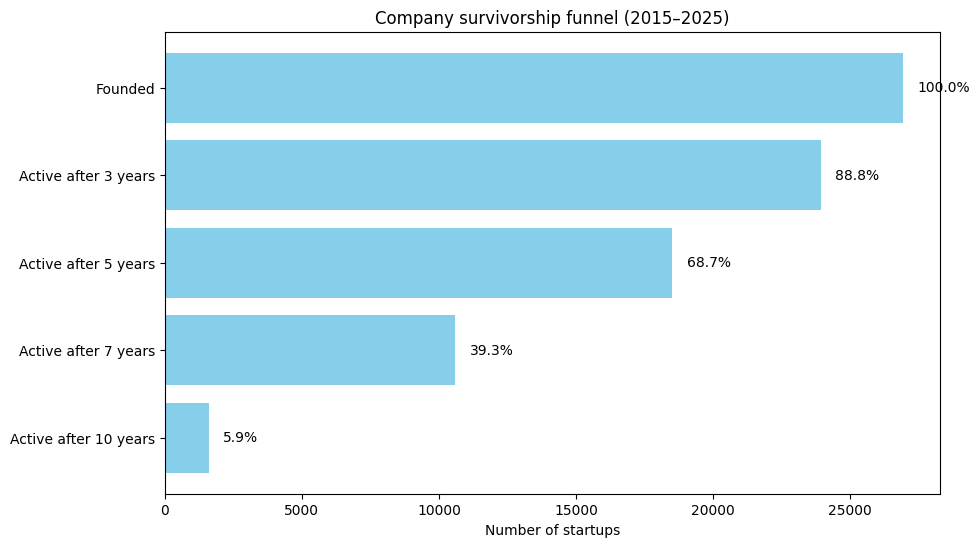

In [6]:
# startup survivorship data
query_survivorship = """
SELECT
start_year,
COUNT(*) AS total_startups,
SUM(CASE WHEN (start_year + 3 <= EXTRACT(YEAR FROM CURRENT_DATE)) AND s.is_active THEN 1 ELSE 0 END) AS active_after_3_years,
SUM(CASE WHEN (start_year + 5 <= EXTRACT(YEAR FROM CURRENT_DATE)) AND s.is_active THEN 1 ELSE 0 END) AS active_after_5_years,
SUM(CASE WHEN (start_year + 7 <= EXTRACT(YEAR FROM CURRENT_DATE)) AND s.is_active THEN 1 ELSE 0 END) AS active_after_7_years,
SUM(CASE WHEN (start_year + 10 <= EXTRACT(YEAR FROM CURRENT_DATE)) AND s.is_active THEN 1 ELSE 0 END) AS active_after_10_years
FROM company c
JOIN status s ON c.status_id = s.status_id
WHERE start_year is not null and start_year > 2014 AND start_year < 2025
GROUP BY start_year
ORDER BY start_year;

"""


df_survivorship = pd.read_sql(query_survivorship, conn)

total_startups = df_survivorship['total_startups'].sum()
active_3 = df_survivorship['active_after_3_years'].sum()
active_5 = df_survivorship['active_after_5_years'].sum()
active_7 = df_survivorship['active_after_7_years'].sum()
active_10 = df_survivorship['active_after_10_years'].sum()

funnel_data = pd.DataFrame({
    'Stage': [
        'Founded',
        'Active after 3 years',
        'Active after 5 years',
        'Active after 7 years',
        'Active after 10 years'
    ],
    'Count': [total_startups, active_3, active_5, active_7, active_10]
})

funnel_data['Percentage'] = (funnel_data['Count'] / total_startups * 100).round(1)
funnel_data['Label'] = funnel_data['Percentage'].astype(str) + '%'

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(funnel_data['Stage'], funnel_data['Count'], color='skyblue')

plt.xlabel('Number of startups')
plt.title('Company survivorship funnel (2015–2025)')
plt.gca().invert_yaxis()  # Keep "Founded" at the top

# Add labels to bars
for bar, label in zip(bars, funnel_data['Label']):
    plt.text(
        bar.get_width() + max(funnel_data['Count']) * 0.02,  # slightly to the right of the bar
        bar.get_y() + bar.get_height()/2,
        label,
        va='center'
    )

plt.show()


